In [1]:
import torch
import numpy as np
from sklearn.cluster import KMeans

# --- Core Update Functions ---
def update_pi_CCLBM(X, tau, pi_k, learning_rate):
    logits = X @ pi_k
    logits = logits - logits.max(dim=1, keepdim=True)[0]  # stabilize softmax
    soft_tau = torch.softmax(logits, dim=1)
    grad = X.T @ (tau - soft_tau)
    N = X.shape[0]
    pi_k = pi_k + (learning_rate / N) * grad

    # Clip and normalize
    pi_k = torch.clamp(pi_k, min=-5.0, max=5.0)
    pi_k = pi_k / (pi_k.norm(dim=0, keepdim=True) + 1e-10)
    return pi_k

def update_beta_CCLBM(X, y, tau, nu, reg=1e-6):
    N, p = X.shape
    K, _, Q = nu.shape
    beta = torch.zeros(K, Q, device=X.device)
    for k in range(K):
        D_tau = torch.diag(tau[:, k])
        X_tilde = nu[k].T @ X.T @ D_tau
        XtX = X_tilde @ X @ nu[k] + reg * torch.eye(Q, device=X.device)
        Xty = X_tilde @ y
        beta_k = torch.linalg.solve(XtX, Xty).squeeze()
        beta[k] = beta_k
    return beta

def update_tau_CCLBM(X, y, pi_k, beta, nu, sigma2_k):
    N, p = X.shape
    K, Q = beta.shape
    logits = X @ pi_k
    logits = logits - logits.max(dim=1, keepdim=True)[0]
    prior_probs = torch.softmax(logits, dim=1)
    log_y_prob = torch.zeros(N, K, device=X.device)
    for k in range(K):
        X_proj = X @ nu[k]
        y_pred = X_proj @ beta[k]
        var_k = sigma2_k[k].clamp(min=1e-5)
        log_pdf = -0.5 * torch.log(2 * torch.pi * var_k) - 0.5 * ((y.squeeze() - y_pred) ** 2) / var_k
        log_y_prob[:, k] = log_pdf
    log_prior = torch.log(prior_probs + 1e-10)
    Tik = log_y_prob + log_prior
    return torch.softmax(Tik, dim=1)

def update_sigma_CCLBM(X, y, tau, beta, nu):
    K, Q = beta.shape
    sigma2_k = torch.zeros(K, device=X.device)
    for k in range(K):
        X_proj = X @ nu[k]
        y_pred = X_proj @ beta[k]
        residuals = (y.squeeze() - y_pred) ** 2
        weighted_residuals = tau[:, k] * residuals
        sigma2_k[k] = weighted_residuals.sum() / (tau[:, k].sum() + 1e-10)
    return torch.clamp(sigma2_k, min=1e-5)

def update_nu_CCLBM2(X, y, tau, beta, rho_ks, sigma2_k):
    N, p = X.shape
    K, Q = beta.shape
    V_kjs = torch.zeros(K, p, Q, device=X.device)
    for k in range(K):
        for j in range(p):
            for s in range(Q):
                nu_tilde = torch.zeros(p, Q, device=X.device)
                nu_tilde[j, s] = 1.0
                X_proj = X @ nu_tilde
                y_pred = X_proj @ beta[k]
                var_k = sigma2_k[k].clamp(min=1e-5)
                log_pdf = -0.5 * torch.log(var_k) - 0.5 * ((y.squeeze() - y_pred) ** 2) / var_k
                weighted_log_pdf = tau[:, k] * log_pdf
                log_prior = torch.log(rho_ks[k, s] + 1e-10)
                V_kjs[k, j, s] = log_prior + weighted_log_pdf.sum()
    return torch.softmax(V_kjs, dim=2)

def update_rho_CCLBM(nu):
    K, p, Q = nu.shape
    rho_ks = (nu.sum(dim=1) + 1) / (p + Q)
    return torch.clamp(rho_ks, min=1e-10)

def ELBO_CCLBM(X, y, tau, pi_k, beta, nu, rho_ks, sigma2_k):
    N, p = X.shape
    K, Q = beta.shape
    elbo = 0.0
    for k in range(K):
        X_proj = X @ nu[k]
        y_pred = X_proj @ beta[k]
        var_k = sigma2_k[k].clamp(min=1e-5)
        log_lik = -0.5 * torch.log(2 * torch.pi * var_k) - 0.5 * ((y.squeeze() - y_pred) ** 2) / var_k
        elbo += (tau[:, k] * log_lik).sum()
    logits = X @ pi_k
    logits = logits - logits.max(dim=1, keepdim=True)[0]
    log_prior_z = torch.log_softmax(logits, dim=1)
    elbo += (tau * log_prior_z).sum()
    elbo -= (tau * torch.log(tau + 1e-10)).sum()
    elbo -= (nu * torch.log(nu + 1e-10)).sum()
    log_rho = torch.log(rho_ks + 1e-10)
    elbo += (nu * log_rho.unsqueeze(1)).sum()
    return elbo.item() if not torch.isnan(elbo) else float('-inf')

# --- MoEBIUS Model Class ---
class MoEBIUSModel:
    def __init__(self, K, Q, max_iter=100, lr_pi=1e-2, lr_beta=1e-2, tol=1e-4, verbose=True,
                 normalize=True, tau_smooth=0.8, nu_smooth=0.8):
        self.K = K
        self.Q = Q
        self.max_iter = max_iter
        self.lr_pi = lr_pi
        self.lr_beta = lr_beta
        self.tol = tol
        self.verbose = verbose
        self.normalize = normalize
        self.tau_smooth = tau_smooth
        self.nu_smooth = nu_smooth
        self.elbo_history = []

    def fit(self, X, y):
        N, p = X.shape
        device = X.device

        if self.normalize:
            self.X_mean = X.mean(0, keepdim=True)
            self.X_std = X.std(0, keepdim=True) + 1e-6
            self.y_mean = y.mean()
            self.y_std = y.std() + 1e-6
            X = (X - self.X_mean) / self.X_std
            y = (y - self.y_mean) / self.y_std

        kmeans_tau = KMeans(n_clusters=self.K, n_init=10).fit(X.cpu().numpy())
        tau_labels = kmeans_tau.labels_
        tau = torch.zeros(N, self.K, device=device)
        tau[torch.arange(N), tau_labels] = 1.0

        nu = torch.zeros(self.K, p, self.Q, device=device)
        for k in range(self.K):
            indices = tau_labels == k
            if indices.sum() == 0:
                nu[k, :, torch.randint(0, self.Q, (p,))] = 1.0
            else:
                X_k = X[indices]
                km = KMeans(n_clusters=self.Q, n_init=10).fit(X_k.T.cpu().numpy())
                for j in range(p):
                    nu[k, j, km.labels_[j % self.Q]] = 1.0

        pi_k = torch.randn(p, self.K, device=device)

        #beta = torch.randn(self.K, self.Q, device=device)
        beta = torch.zeros(self.K, self.Q, device=device)
        for k in range(self.K):
            idx = tau_labels == k
            if idx.sum() > 0:
                X_k = X[idx] @ nu[k]
                y_k = y[idx]
                XtX = X_k.T @ X_k + self.lr_beta * torch.eye(self.Q, device=device)
                Xty = X_k.T @ y_k
                beta[k] = torch.linalg.solve(XtX, Xty).squeeze()
            else:
                beta[k] = torch.randn(self.Q, device=device)

        sigma2_k = torch.ones(self.K, device=device)
        rho_ks = torch.ones(self.K, self.Q, device=device) / self.Q

        for it in range(self.max_iter):
            old_elbo = self.elbo_history[-1] if self.elbo_history else None

            tau_new = update_tau_CCLBM(X, y, pi_k, beta, nu, sigma2_k)
            tau = self.tau_smooth * tau_new + (1 - self.tau_smooth) * getattr(self, 'tau_old', tau_new)
            self.tau_old = tau.detach()


            pi_k = update_pi_CCLBM(X, tau, pi_k, self.lr_pi)
            beta = update_beta_CCLBM(X, y, tau, nu, reg=self.lr_beta)
            sigma2_k = update_sigma_CCLBM(X, y, tau, beta, nu)

            nu_new = update_nu_CCLBM2(X, y, tau, beta, rho_ks, sigma2_k)
            nu = self.nu_smooth * nu_new + (1 - self.nu_smooth) * getattr(self, 'nu_old', nu_new)
            self.nu_old = nu.detach()

            rho_ks = update_rho_CCLBM(nu)

            elbo = ELBO_CCLBM(X, y, tau, pi_k, beta, nu, rho_ks, sigma2_k)
            self.elbo_history.append(elbo)

            if self.verbose:
                print(f"Iter {it+1:03d} | ELBO: {elbo:.4f} | σ² min: {sigma2_k.min():.2e} max: {sigma2_k.max():.2e}")

            if old_elbo is not None and abs(elbo - old_elbo) < self.tol:
                if self.verbose:
                    print("✅ Converged.")
                break

        self.pi_k, self.beta, self.nu = pi_k, beta, nu
        self.tau, self.sigma2_k, self.rho_ks = tau, sigma2_k, rho_ks
        self.elbo_final = elbo
        return self

    def predict(self, X):
        if self.normalize:
            X = (X - self.X_mean) / self.X_std
        tau = torch.softmax(X @ self.pi_k, dim=1)
        y_per_k = torch.stack([(X @ self.nu[k]) @ self.beta[k] for k in range(self.K)], dim=1)
        y_pred = (tau * y_per_k).sum(dim=1)
        if self.normalize:
            y_pred = y_pred * self.y_std + self.y_mean
        return y_pred

    def score(self, X, y_true):
        y_pred = self.predict(X)
        return torch.mean((y_pred - y_true.squeeze()) ** 2).item()

Iter 001 | ELBO: -915.9919 | σ² min: 2.94e-01 max: 4.38e-01
Iter 002 | ELBO: -530.9622 | σ² min: 3.18e-01 max: 4.19e-01
Iter 003 | ELBO: -480.5054 | σ² min: 3.05e-01 max: 3.90e-01
Iter 004 | ELBO: -482.9695 | σ² min: 2.97e-01 max: 3.87e-01
Iter 005 | ELBO: -471.8734 | σ² min: 2.94e-01 max: 3.97e-01
Iter 006 | ELBO: -479.5969 | σ² min: 2.86e-01 max: 3.95e-01
Iter 007 | ELBO: -470.0318 | σ² min: 2.84e-01 max: 4.04e-01
Iter 008 | ELBO: -478.1322 | σ² min: 2.77e-01 max: 4.01e-01
Iter 009 | ELBO: -468.7934 | σ² min: 2.75e-01 max: 4.08e-01
Iter 010 | ELBO: -476.9164 | σ² min: 2.69e-01 max: 4.04e-01
Iter 011 | ELBO: -467.6128 | σ² min: 2.68e-01 max: 4.10e-01
Iter 012 | ELBO: -475.6957 | σ² min: 2.62e-01 max: 4.05e-01
Iter 013 | ELBO: -466.3341 | σ² min: 2.60e-01 max: 4.11e-01
Iter 014 | ELBO: -474.3796 | σ² min: 2.54e-01 max: 4.05e-01
Iter 015 | ELBO: -464.9514 | σ² min: 2.53e-01 max: 4.11e-01
Iter 016 | ELBO: -472.9348 | σ² min: 2.47e-01 max: 4.05e-01
Iter 017 | ELBO: -463.4097 | σ² min: 2.4

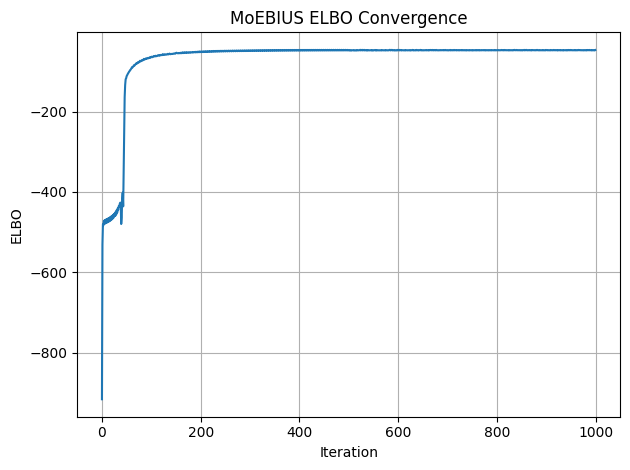

In [7]:
import torch
import pandas as pd
import matplotlib.pyplot as plt

# --- Load CSV Data ---
X_train = pd.read_csv("X_train.csv").values.astype("float32")
y_train = pd.read_csv("y_train.csv")["y"].values.astype("float32")
X_test = pd.read_csv("X_test.csv").values.astype("float32")
y_test = pd.read_csv("y_test.csv")["y"].values.astype("float32")

# Convert to torch tensors
X_train_torch = torch.tensor(X_train)
y_train_torch = torch.tensor(y_train).unsqueeze(1)
X_test_torch = torch.tensor(X_test)
y_test_torch = torch.tensor(y_test).unsqueeze(1)

# --- Train MoEBIUS ---
model = MoEBIUSModel(
    K=3,
    Q=4,
    lr_pi=  0.1,
    lr_beta=0.1,
     max_iter=1000,
     tau_smooth=0.8,
     nu_smooth=0.8,
     normalize=True
)
model.fit(X_train_torch, y_train_torch)

# --- Evaluate ---
mse_train = model.score(X_train_torch, y_train_torch)
mse_test = model.score(X_test_torch, y_test_torch)

print("\n📊 MoEBIUS Final Results:")
print(f"Train MSE: {mse_train:.4f}")
print(f"Test  MSE: {mse_test:.4f}")

# --- Plot ELBO Convergence ---
plt.plot(model.elbo_history)
plt.xlabel("Iteration")
plt.ylabel("ELBO")
plt.title("MoEBIUS ELBO Convergence")
plt.grid(True)
plt.tight_layout()
plt.show()
